https://cs231n.github.io/

In [1]:
#!git clone git@github.com:alexeygrigorev/clothing-dataset-small.git

## 8.2 TensorFlow and Keras

* Installing TensorFlow
* Loading Images

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
from pathlib import Path

In [5]:
from tensorflow.keras.preprocessing.image import load_img

In [6]:
path = './clothing-dataset-small/train/t-shirt/'
name = '00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg'

fullname = Path(path, name)

In [7]:
img = load_img(fullname, target_size=(299,299))

In [8]:
print(img)

<PIL.Image.Image image mode=RGB size=299x299 at 0x12F033D90>


In [9]:
#Turn image to a numpy array

x = np.array(img)
x.shape

(299, 299, 3)

## 8.3 Pre-trainded convolutional neural networks

* Imagenet dataset: https://www.image-net.org
* Pre-trained models: https://keras.io/api/applications/

In [10]:
from tensorflow.keras.applications.xception import Xception
#adding a preprocessing function
from tensorflow.keras.applications.xception import preprocess_input
#adding decoding predictions
from tensorflow.keras.applications.xception import decode_predictions

In [11]:
model = Xception(weights = 'imagenet', input_shape=(299,299,3))

In [12]:
X=np.array([x])
X.shape

(1, 299, 299, 3)

In [13]:
X=preprocess_input(X)

In [14]:
pred = model.predict([X])
pred.shape

/Users/AKhvatov/.local/share/virtualenvs/machine-learning-zoomcamp-homework-bLdGrrwV/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=('*',)
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


(1, 1000)

In [15]:
decode_predictions(pred)

[[('n03595614', 'jersey', np.float32(0.8878354)),
  ('n03710637', 'maillot', np.float32(0.0068345186)),
  ('n04456115', 'torch', np.float32(0.0064636283)),
  ('n02730930', 'apron', np.float32(0.0059278416)),
  ('n04235860', 'sleeping_bag', np.float32(0.0054279147))]]

## 8.4 Convolutional neural networks

* Types of layers: convolutional and dense
* Convolutional layers and filters
* Dense layers

There are more layers. Read here: https://cs231n.github.io/

Convolutional layers -- small 'filters'. 5x5 - contain smile shapes


![conv_networks](images/conv_networks.jpg "a title")

NOT for binary classification (when we have more than one item we try to id) we can buld several models = # of items

![multi model](images/multi_model.jpg "a title")

Sigmoid for multiple classes is called `Softmax` produces 3dim output probabilities of shirt, t shirt and dress 

![dense_layer.jpg](images/dense_layer.jpg)

## 8.5 Transfer learning
    * Reading data with `ImageDataGenerator`
    * Train `Xception` on smaller images (150x150)

(better to run with GPU)

The idea is to be able to re-use conf layers and vector representation for the new model

![transfer_learning](images/transfer_learning.jpg)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
train_ds=train_gen.flow_from_directory('./clothing-dataset-small/train/', target_size=(150, 150), batch_size=32)

Found 3069 images belonging to 10 classes.


In [19]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [25]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [26]:
X, y = next(train_ds)

In [27]:
X.shape

(32, 150, 150, 3)

In [28]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

the above used one-hot encoding

In [31]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds=val_gen.flow_from_directory('./clothing-dataset-small/validation', target_size=(150, 150), batch_size=32, shuffle=False)
X, y = next(train_ds)

Found 341 images belonging to 10 classes.


In [33]:
#we can now create a base model
#we will train custom model based on the base model


Meaning of `include_top` in the below code


![include_top](images/top_bottom.jpg)

In [36]:
base_model = Xception(weights='imagenet', include_top=False,  input_shape=(150, 150, 3))
base_model.trainable = False

In [38]:
# we are ready to create new 'top'

inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs)

In [39]:
outputs = base

In [40]:
model= keras.Model(inputs, outputs)

In [44]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


In [46]:
pred.shape

(32, 5, 5, 2048)

Pooling (average of squares) from 3D to 1D - taking average.

In [49]:
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs)

pooling = keras.layers.GlobalAveragePooling2D()
vectors = pooling(base)

outputs = vectors
model = keras.Model(inputs, outputs)


In [50]:
preds = model.predict(X)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


(32, 2048)

In [53]:
# Functional style

inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = vectors
model = keras.Model(inputs, outputs)

preds = model.predict(X)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


(32, 2048)

In [59]:
#Convert predictions to classes (this is V1 model)

inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

preds = model.predict(X)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


(32, 10)

In [60]:
preds[0]

array([-0.17429954, -0.21456844,  0.6532952 , -0.6413605 ,  0.4802548 ,
        1.1268492 ,  0.2743045 ,  0.42913866,  0.8113518 ,  0.17062539],
      dtype=float32)

In [62]:
#this was not a real model
# we actually need to train the model
# we use OPTIMIZER to do it
learning_rate = 0.01

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
#loss tells us how good the model is
loss = keras.losses.CategoricalCrossentropy(from_logits=True) #the lower the better




In [68]:
##RERUN to make it work...

#Softmax is called activation

# by setting `from_logits` we use the raw score
base_model = Xception(weights='imagenet', include_top=False,  input_shape=(150, 150, 3))
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)


In [71]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True) #the lower the better

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
#epoch = numbe of time to go over the data

              

In [72]:
history = model.fit(train_ds, epochs= 10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 336ms/step - accuracy: 0.7781 - loss: 0.8417 - val_accuracy: 0.7683 - val_loss: 1.0460
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 333ms/step - accuracy: 0.8737 - loss: 0.4335 - val_accuracy: 0.7595 - val_loss: 1.3019
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 332ms/step - accuracy: 0.8939 - loss: 0.3455 - val_accuracy: 0.7830 - val_loss: 0.9708
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 335ms/step - accuracy: 0.9536 - loss: 0.1439 - val_accuracy: 0.7977 - val_loss: 1.0395
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 336ms/step - accuracy: 0.9584 - loss: 0.1129 - val_accuracy: 0.8211 - val_loss: 0.8779
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 328ms/step - accuracy: 0.9781 - loss: 0.0746 - val_accuracy: 0.8123 - val_loss: 0.9920
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 329ms/step - accuracy: 0.9684 - loss: 0.0987 - val_accuracy: 0.7889 - val_loss: 1.2034
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 338ms/step - accuracy: 0.9738 - loss: 0.0886 - val_accu

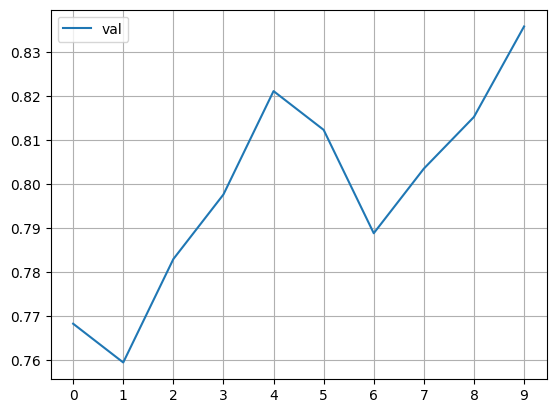

In [83]:
#plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.grid()
plt.legend()

## 8.6 Adjusting the learning rate

    * What's the learning rate
    * Trying different values

In [84]:
# Learning rate is how fast you can read

In [85]:
def  make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet', 
        include_top=False,  
        input_shape=(150, 150, 3)
    )
    
    base_model.trainable = False
    #==================
    
    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    #====================
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True) #the lower the better
    
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model


In [107]:
scores ={}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(f"Learning rate: {lr}")
    
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs= 10, validation_data=val_ds)
    scores[lr] = history.history
    print()
    print()

Learning rate: 0.0001
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 329ms/step - accuracy: 0.3541 - loss: 1.8995 - val_accuracy: 0.6100 - val_loss: 1.1725
Epoch 2/10
83/96 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.6721 - loss: 1.0288

KeyboardInterrupt: 

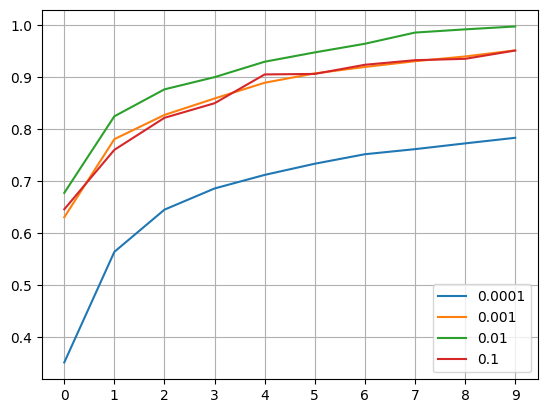

In [89]:
for lr, hist in scores.items():
    #plt.plot(history.history['accuracy'], label = 'train')
    plt.plot(hist['accuracy'], label=lr)


plt.xticks(np.arange(10))
plt.grid()
plt.legend()

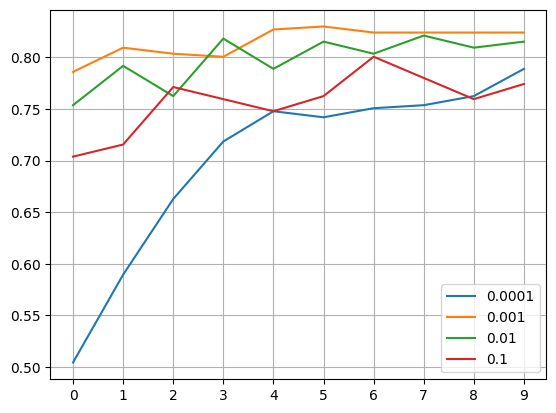

In [91]:
#looking at validation

for lr, hist in scores.items():
    #plt.plot(history.history['accuracy'], label = 'train')
    plt.plot(hist['val_accuracy'], label=lr)


plt.xticks(np.arange(10))
plt.grid()
plt.legend()

In [92]:
# we will remove bad performance and replot
del scores[0.1]
del scores[0.0001]

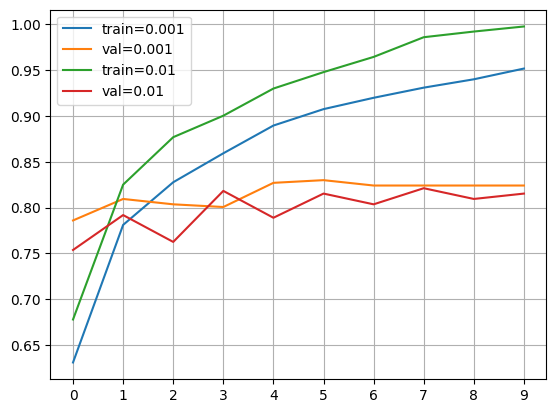

In [94]:
#looking at validation

for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label = f'train={lr}')
    plt.plot(hist['val_accuracy'], label=f'val={lr}')


plt.xticks(np.arange(10))
plt.grid()
plt.legend()


In [ ]:
#Learning rate should be 0.001 since it performs better! b/c the distance between train and val (vertically) is smaller in 0.001

In [95]:
learning_rate = 0.001

## 8.7 Checkpointing

    * Saving the best model only
    * Training a model with callbacks

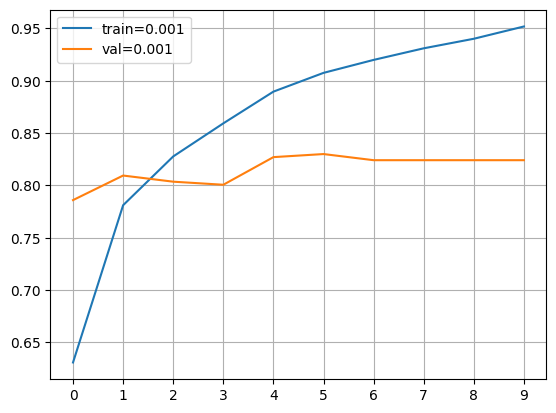

In [96]:
lr = 0.001
hist = scores[lr]
plt.plot(hist['accuracy'], label = f'train={lr}')
plt.plot(hist['val_accuracy'], label=f'val={lr}')
plt.xticks(np.arange(10))
plt.grid()
plt.legend()


In [ ]:
#we would like to save the model on iteration #5 b/c it produces a better result w/o overfitting.

In [99]:
checkpoint = keras.callbacks.ModelCheckpoint('xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
                               save_best_only=True,
                               monitor='val_accuracy',
                               mode='max')

In [97]:
#saving only the best only (if there is an improvement)

In [100]:
learning_rate = 0.001
model = make_model(learning_rate=learning_rate)
history = model.fit(train_ds, 
                    epochs= 10, 
                    validation_data=val_ds,
                   callbacks=[checkpoint])


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 324ms/step - accuracy: 0.5242 - loss: 1.4309 - val_accuracy: 0.7771 - val_loss: 0.7099
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 312ms/step - accuracy: 0.7849 - loss: 0.6462 - val_accuracy: 0.7977 - val_loss: 0.6295
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 312ms/step - accuracy: 0.8284 - loss: 0.5044 - val_accuracy: 0.8094 - val_loss: 0.5889
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 314ms/step - accuracy: 0.8642 - loss: 0.4288 - val_accuracy: 0.8182 - val_loss: 0.5619
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 312ms/step - accuracy: 0.8767 - loss: 0.3768 - val_accuracy: 0.8152 - val_loss: 0.5308
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 312ms/step - accuracy: 0.9065 - loss: 0.3339 - val_accuracy: 0.8035 - val_loss: 0.5378
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 314ms/step - accuracy: 0.9307 - loss: 0.2789 - val_accuracy: 0.8211 - val_loss: 0.5463
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 314ms/step - accuracy: 0.9440 - loss: 0.2446 - val_accu

## 8.8 Adding more layers
    * Adding one inner dense layer
    * Experimenting with different sizes of inner layer

In [101]:
def  make_model(learning_rate=0.01, size_inner = 100):
    base_model = Xception(
        weights='imagenet', 
        include_top=False,  
        input_shape=(150, 150, 3)
    )
    
    base_model.trainable = False
    #==================
    
    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    #adding more layers here
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(10)(inner)
    model = keras.Model(inputs, outputs)
    #====================
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True) #the lower the better
    
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model


Activation functions:

    * sigmoid
    * softmax

    * relu
    

relu - default activation function

In [104]:
learning_rate = 0.001

scores ={}
for size in [10, 100, 1000]:
    print(f"Size inner: {size}")
    
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs= 10, validation_data=val_ds)
    scores[size] = history.history
    print()
    print()

Size inner: 10
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 331ms/step - accuracy: 0.3222 - loss: 1.9987 - val_accuracy: 0.6686 - val_loss: 1.1772
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 316ms/step - accuracy: 0.6508 - loss: 1.1221 - val_accuracy: 0.7507 - val_loss: 0.8615
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 315ms/step - accuracy: 0.7490 - loss: 0.7873 - val_accuracy: 0.7419 - val_loss: 0.7718
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 316ms/step - accuracy: 0.7790 - loss: 0.6358 - val_accuracy: 0.7625 - val_loss: 0.7072
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 317ms/step - accuracy: 0.8109 - loss: 0.5569 - val_accuracy: 0.7713 - val_loss: 0.6724
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 318ms/step - accuracy: 0.8365 - loss: 0.5016 - val_accuracy: 0.7566 - val_loss: 0.6755
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 318ms/step - accuracy: 0.8602 - loss: 0.4405 - val_accuracy: 0.7947 - val_loss: 0.6451
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 320ms/step - accuracy: 0.8679 - loss: 0.

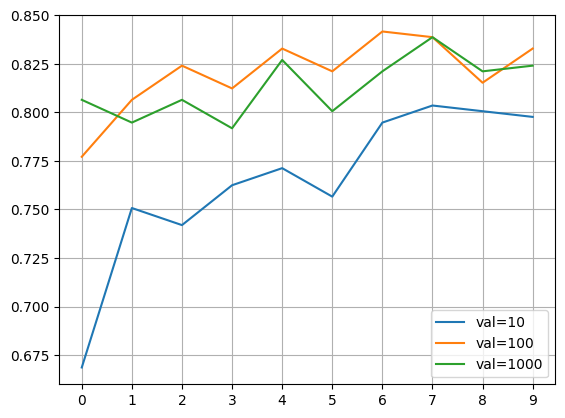

In [105]:
#looking at validation

for size, hist in scores.items():
    #plt.plot(hist['accuracy'], label = f'train={size}')
    plt.plot(hist['val_accuracy'], label=f'val={size}')


plt.xticks(np.arange(10))
plt.grid()
plt.legend()

In [106]:
#IN this chart it seems size 100 is the best (val accuracy is the highest at 6th epoch)

## 8.9 Regularization and dropout

    * Regularizing by freezing a part of the network
    * Adding dropout to our model
    * Experimenting with different values

In [108]:
#Adding dropout:
def  make_model(learning_rate=0.01, size_inner = 100, droprate=0.5):
    base_model = Xception(
        weights='imagenet', 
        include_top=False,  
        input_shape=(150, 150, 3)
    )
    
    base_model.trainable = False
    #==================
    
    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    #adding more layers here
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    #0.2 -- 20% drop rate
    
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    #====================
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True) #the lower the better
    
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

![drop layer](images/drop_layer.png)

In [109]:
learning_rate = 0.001
size = 100

scores ={}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(f"drop rate: {droprate}")
    
    model = make_model(
        learning_rate=learning_rate, 
        size_inner=size, 
        droprate=droprate
    )

    
    history = model.fit(train_ds, epochs= 30, validation_data=val_ds)
    scores[droprate] = history.history
    print()
    print()

#NOTE: here we had to increase number of epochs b/c neural network will require more iteratons

drop rate: 0.0
Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 324ms/step - accuracy: 0.5461 - loss: 1.3245 - val_accuracy: 0.7771 - val_loss: 0.6409
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 325ms/step - accuracy: 0.8169 - loss: 0.5065 - val_accuracy: 0.8094 - val_loss: 0.5715
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 323ms/step - accuracy: 0.8960 - loss: 0.3297 - val_accuracy: 0.8240 - val_loss: 0.5642
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 331ms/step - accuracy: 0.9216 - loss: 0.2693 - val_accuracy: 0.8240 - val_loss: 0.5320
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 330ms/step - accuracy: 0.9456 - loss: 0.1896 - val_accuracy: 0.8211 - val_loss: 0.5625
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 327ms/step - accuracy: 0.9623 - loss: 0.1411 - val_accuracy: 0.8182 - val_loss: 0.5531
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 314ms/step - accuracy: 0.9828 - loss: 0.0930 - val_accuracy: 0.8358 - val_loss: 0.5445
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 314ms/step - accuracy: 0.9904 - loss: 0.

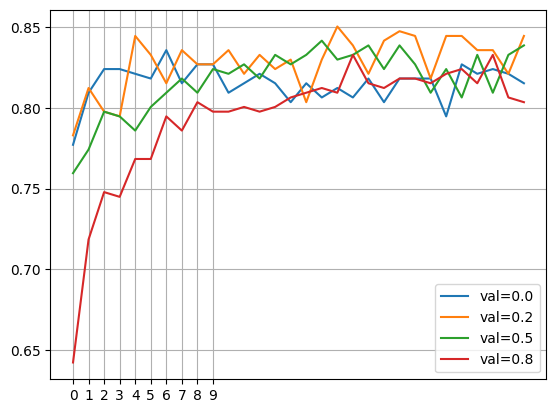

In [110]:
#looking at validation

for droprate, hist in scores.items():
    #plt.plot(hist['accuracy'], label = f'train={size}')
    plt.plot(hist['val_accuracy'], label=f'val={droprate}')


plt.xticks(np.arange(10))
plt.grid()
plt.legend()

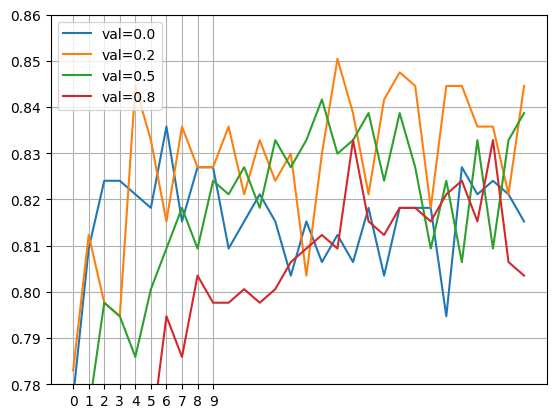

In [111]:
#looking at validation

for droprate, hist in scores.items():
    #plt.plot(hist['accuracy'], label = f'train={size}')
    plt.plot(hist['val_accuracy'], label=f'val={droprate}')


plt.xticks(np.arange(10))
plt.grid()
plt.ylim(0.78, 0.86)
plt.legend()

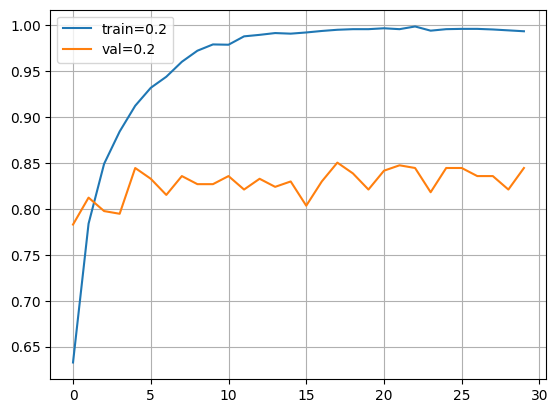

In [117]:
hist = scores[0.2]
plt.plot(hist['accuracy'], label = f'train=0.2')
plt.plot(hist['val_accuracy'], label=f'val=0.2')
#plt.xticks(np.arange(10))
plt.grid()
#plt.ylim(0.78, 0.86)
plt.legend()

#Performance is better

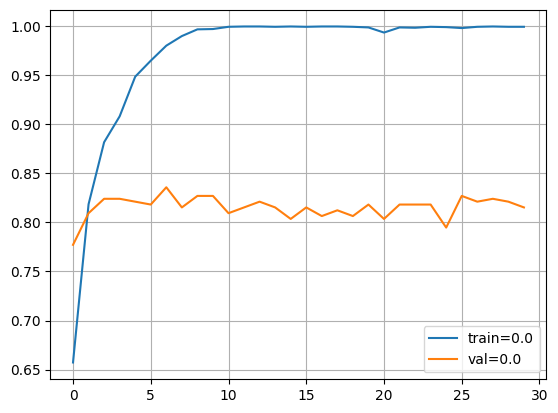

In [118]:
#NO regularizaion
hist = scores[0.0]
plt.plot(hist['accuracy'], label = f'train=0.0')
plt.plot(hist['val_accuracy'], label=f'val=0.0')
#plt.xticks(np.arange(10))
plt.grid()
#plt.ylim(0.78, 0.86)
plt.legend()

#Overfits

In [119]:
#We should go with 0.2 to prevent overfitting

## 8.10 Data augmentation

    * Different data augmentations
    * Training a model with arguments
    * How to select data augmentations?


### Transformations:


    * rotation
    * flip
    * shift
    * shear
    * zoom-(in - out)
    * brightness/contrast

    
    * you can combine them
    * there are other libraries available

In [131]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                          # did not work -- commenting out -- rotation_range=30,
   #also did not help--- width_shift_range=10.0,
   # did not help height_shift_range=10.0,
   # commenting out shear b/c it is not producing good results shear_range=1.0, #reapplying with less-agressive shearing (was 10)
   # leaving out zoom  zoom_range=0.1,
    vertical_flip=True)

train_ds=train_gen.flow_from_directory('./clothing-dataset-small/train/', target_size=(150, 150), batch_size=32)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation/', target_size=(150, 150), batch_size=32, shuffle=False)

Found 3069 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


Choosing augmentations

* use  your own judgement (does not make sense to flip up side down )
* look at the dataset white kind of varations are there
* are the objects always scentered (rotate, shift)
* tune it as a hyper parameter
* train for 10-20 epochs is it better or worse
* train for more epochs
* 

In [132]:
learning_rate = 0.001
size = 100
droprate = 0.2


print(f"drop rate: {droprate}")

model = make_model(
    learning_rate=learning_rate, 
    size_inner=size, 
    droprate=droprate
)


history = model.fit(train_ds, epochs= 50, validation_data=val_ds)


drop rate: 0.2
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 320ms/step - accuracy: 0.4851 - loss: 1.5682 - val_accuracy: 0.7507 - val_loss: 0.7391
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 315ms/step - accuracy: 0.7193 - loss: 0.8439 - val_accuracy: 0.7683 - val_loss: 0.6849
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 317ms/step - accuracy: 0.7777 - loss: 0.6634 - val_accuracy: 0.7830 - val_loss: 0.6483
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 315ms/step - accuracy: 0.7994 - loss: 0.6021 - val_accuracy: 0.7713 - val_loss: 0.6223
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 315ms/step - accuracy: 0.8126 - loss: 0.5448 - val_accuracy: 0.7918 - val_loss: 0.5935
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 315ms/step - accuracy: 0.8435 - loss: 0.4675 - val_accuracy: 0.7830 - val_loss: 0.5973
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 314ms/step - accuracy: 0.8390 - loss: 0.4581 - val_accuracy: 0.8035 - val_loss: 0.5563
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 326ms/step - accuracy: 0.8695 - loss: 0.

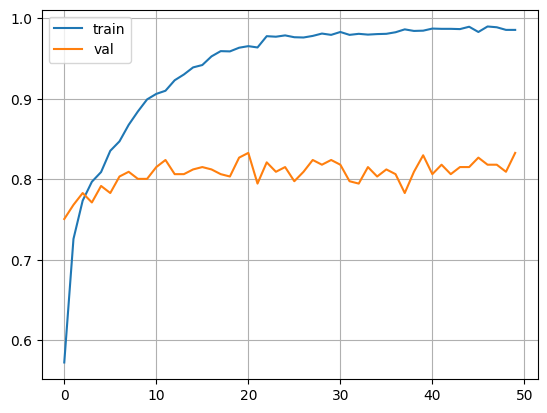

In [133]:
plt.plot(history.history['accuracy'], label = f'train')
plt.plot(history.history['val_accuracy'], label=f'val')
#plt.xticks(np.arange(10))
plt.grid()
#plt.ylim(0.78, 0.86)
plt.legend()

Tuning neural networks is more art than science

## 8.11 Training a larger model
* Train a 299x299 model

In [143]:
#Adding dropout:
def  make_model(input_size = 150, learning_rate=0.01, size_inner = 100, droprate=0.5):
    base_model = Xception(
        weights='imagenet', 
        include_top=False,  
        input_shape=(input_size, input_size, 3)
    )
    
    base_model.trainable = False
    #==================
    
    inputs = keras.Input(shape=(input_size, input_size, 3))
    
    base = base_model(inputs, training=False)
    
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    #adding more layers here
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    #0.2 -- 20% drop rate
    
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    #====================
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True) #the lower the better
    
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

In [144]:
input_size = 299

In [149]:
#using augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                              shear_range = 10,
                              zoom_range=0.1,
                              horizontal_flip=True
                              )

train_ds=train_gen.flow_from_directory('./clothing-dataset-small/train/', target_size=(input_size, input_size), batch_size=32)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation/', target_size=(input_size, input_size), batch_size=32, shuffle=False)

Found 3069 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [150]:
checkpoint = keras.callbacks.ModelCheckpoint('xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.keras',
                               save_best_only=True,
                               monitor='val_accuracy',
                               mode='max')

In [152]:
learning_rate = 0.0005
size = 100
droprate = 0.2



print(f"drop rate: {droprate}")

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate, 
    size_inner=size, 
    droprate=droprate
)


history = model.fit(train_ds, epochs= 50, validation_data=val_ds, callbacks=[checkpoint])

drop rate: 0.2
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5854 - loss: 1.3396 - val_accuracy: 0.8534 - val_loss: 0.5148
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.8229 - loss: 0.5628 - val_accuracy: 0.8768 - val_loss: 0.4137
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.8473 - loss: 0.4519 - val_accuracy: 0.8563 - val_loss: 0.3961
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8633 - loss: 0.3893 - val_accuracy: 0.8710 - val_loss: 0.3754
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.8929 - loss: 0.3265 - val_accuracy: 0.8651 - val_loss: 0.3703
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.8914 - loss: 0.3155 - val_accuracy: 0.8768 - val_loss: 0.3787
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9035 - loss: 0.2883 - val_accuracy: 0.8739 - val_loss: 0.3483
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9051 - loss: 0.2864 - val_accur

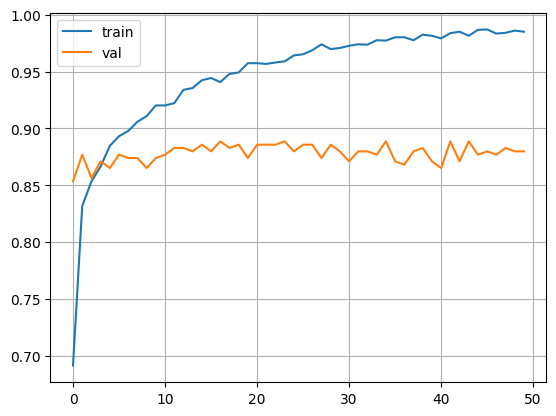

In [153]:
plt.plot(history.history['accuracy'], label = f'train')
plt.plot(history.history['val_accuracy'], label=f'val')
#plt.xticks(np.arange(10))
plt.grid()
#plt.ylim(0.78, 0.86)
plt.legend()

## 8.12 Using the model (RESTARTED KERNEL)

* Loading the model
* Evaluating the model
* Getting predictions
  

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import preprocess_input

In [10]:
model = keras.models.load_model('xception_v4_1_17_0.889.keras')

In [12]:
test_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_ds = test_gen.flow_from_directory('./clothing-dataset-small/validation', 
                                       target_size = (299,299),
                                       batch_size = 32,
                                       shuffle=False
                                      )

Found 341 images belonging to 10 classes.


In [13]:
model.evaluate(test_ds)

/Users/AKhvatov/.local/share/virtualenvs/machine-learning-zoomcamp-homework-bLdGrrwV/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8757 - loss: 0.4046


[0.36816170811653137, 0.8885630369186401]

In [15]:
path = './clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

In [18]:
img = load_img(path, target_size=(299,299))

In [19]:
import numpy as np

In [23]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [24]:
X = preprocess_input(X)

In [25]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


In [27]:
pred[0]

array([-2.7875006, -6.7333694, -2.7166917, -1.7542566, 10.084399 ,
       -2.4668238, -4.72618  ,  3.9924731, -4.711963 , -2.8932369],
      dtype=float32)

In [29]:
classes = ['dress',
 'hat',
 'longsleeve',
 'outwear',
 'pants',
 'shirt',
 'shoes',
 'shorts',
 'skirt',
 't-shirt']

In [30]:
dict(zip(classes, pred[0]))

{'dress': np.float32(-2.7875006),
 'hat': np.float32(-6.7333694),
 'longsleeve': np.float32(-2.7166917),
 'outwear': np.float32(-1.7542566),
 'pants': np.float32(10.084399),
 'shirt': np.float32(-2.4668238),
 'shoes': np.float32(-4.72618),
 'shorts': np.float32(3.9924731),
 'skirt': np.float32(-4.711963),
 't-shirt': np.float32(-2.8932369)}

## 8.13 Summary

* We can use pre-trained models for general image classificaiton
* 